In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from datetime import datetime
from unicodedata import normalize
import time


## Similitud entre titulos de items

### Carga de datos

In [177]:
data_path='../data/'
df_train = pd.read_csv(data_path+'items_titles.csv')

In [178]:
df_train.sample(10)

,ITE_ITEM_TITLE
19853,Tênis Feminino Piccadilly Calce Fácil Leve Con...
14815,Monark Tropical
4890,Tênis Infantil Feminino Rosê Makenzi - Promoção
21100,"adidas Hemp Verde, Usado, Excelente Estado De ..."
23869,Combo C/2 Tenis Feminino Jogging Vivet Original
2048,Tênis adidas Tamanho 37 Tecnologia Non Marking
6077,Tênis Feminino Casual Sapatênis Baixo Camuflad...
26694,Sapatenis Cano Alto Masculino Barato Promoção ...
16766,Tênis De Led Pampili Infantil Sneaker Brilho 1...
22043,Tênis Star Universe Lona Leve Original All B N...


In [140]:
## esta en portugues es un buen dataset para probar y ajustar semantica

#### Primero vamos a crear un metodo para estandarizar nombres (dado que esta en portugues) 

In [179]:


def preprocesamiento_texto(text):
    """Preprocesamiento robusto para títulos de productos"""
    if pd.isna(text):
        return ""
    
    # Convertir a string
    text = str(text)
    
    # Normalizar Unicode (remover acentos)
    text = normalize('NFKD', text).encode('ASCII', 'ignore').decode('ASCII')
    
    # Minusculas
    text = text.lower()
    
    # Remover caracteres especiales
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    
    # Remover espacios múltiples
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text


In [180]:
df_train['title_fix']=df_train['ITE_ITEM_TITLE'].apply(preprocesamiento_texto)


In [181]:
df_train.head(2)

,ITE_ITEM_TITLE,title_fix
0,Tênis Ascension Posh Masculino - Preto E Verme...,tenis ascension posh masculino preto e vermelho
1,Tenis Para Caminhada Super Levinho Spider Corr...,tenis para caminhada super levinho spider corrida


### vamos a entrar  TF IDF 

In [182]:
vectorizer = TfidfVectorizer(
    analyzer='word',
    ngram_range=(1,2),   
    min_df=2,            
    max_features=None,
    strip_accents='unicode',
    lowercase=True,
    #stop_words='portuguese'
)
## para tulizar stop words se puede usar el idioma en este caso portugues pero es necesario un paquete de nltk o spacy


In [183]:
# entrenamos el modelo, esto es una matriz de terminos por documentos (en este caso items) lo que nos permite calcular la similitud entre items
start = time.time()
vectorizer.fit(df_train['title_fix'])
finished = time.time()
print(f"Tiempo de entrenamiento: {finished - start:.4f} segundos")

Tiempo de entrenamiento: 0.6962 segundos


In [184]:
for i in vectorizer.get_feature_names_out():
    if 'bicicleta' in i:
        print(i)
        break

2x bicicleta


In [185]:
#en este paso se transforma test en una matriz de terminos por documentos 
X_train = vectorizer.transform(df_train['title_fix'])

In [186]:
## ahora calculamos la similitud entre items, con la funcion de similitud de coseno

S = cosine_similarity(X_train, dense_output=False)  # sparse

titles = df_train['title_fix'].tolist()
n = len(titles)
k = 2  # los dos más similares (incluye al mismo título)

resultados = []
for i in range(n):
    row = S.getrow(i).toarray().ravel()           
    top_idx = np.argsort(-row)[:k]                
    top_scores = row[top_idx]
    top_titles = [titles[j] for j in top_idx]
    
    resultados.append({
        'title': titles[i],
        'similar_titles': top_titles,
        'similarity_scores': top_scores.tolist()
    })

#guardamos los resultados en un dataframe con el fin de poder usarlo para buscar similitudes
df_resultados_cos = pd.DataFrame(resultados)

In [149]:
#Esto nos pedia el reto
df_flat = df_resultados_cos.explode(['similar_titles', 'similarity_scores']).reset_index(drop=True)
df_flat

,title,similar_titles,similarity_scores
0,tenis ascension posh masculino preto e vermelho,tenis ascension posh masculino preto e vermelho,1.0
1,tenis ascension posh masculino preto e vermelho,tenis ascension voltage masculino preto e verde,0.7074
2,tenis para caminhada super levinho spider corrida,tenis para caminhada super levinho spider corrida,1.0
3,tenis para caminhada super levinho spider corrida,tenis para caminhada,0.481954
4,tenis feminino le parc hocks black ice origina...,tenis feminino le parc hocks black ice origina...,1.0
...,...,...,...
59995,tenis botinha com pelo via marte original lanc...,botinha com pelo tenis via marte outono invern...,0.593455
59996,tenis slip on feminino masculino original sapa...,tenis slip on feminino masculino original sapa...,1.0
59997,tenis slip on feminino masculino original sapa...,tenis slip on feminino masculino xadrez preto ...,0.478493
59998,bicicleta nathor rosa infantil sem pedal balan...,bicicleta nathor rosa infantil sem pedal balan...,1.0


In [150]:
#creamos un metodo para buscar similitudes en batch donde recibimos un titulo y nos devuelve los titulos mas similares y sus scores
def batch_similitud_nn(title):
    print("batch_similitud para Title: ", title)
    processed_title = preprocesamiento_texto(title)
    similar_titles = df_resultados_cos[df_resultados_cos['title'] == processed_title]['similar_titles'].values[0]
    similarity_scores = df_resultados_cos[df_resultados_cos['title'] == processed_title]['similarity_scores'].values[0]
    return similar_titles, similarity_scores


In [151]:
batch_similitud_nn(df_train['ITE_ITEM_TITLE'].iloc[0])

batch_similitud para Title:  Tênis Ascension Posh Masculino - Preto E Vermelho 


(['tenis ascension posh masculino preto e vermelho',
  'tenis ascension voltage masculino preto e verde'],
 [1.0000000000000002, 0.7073995098085812])

### Vamos a crear un pipeline que implemente lo entrenado previaemente a cualquier documento

In [168]:
def pipeline_procesamiento_completo(df_test, vectorizer, top_n=2):
    resultados = {
        'tiempos': {},
        'metricas': {},
        'datos': {}
    }
    
    print("PIPELINE DE PROCESAMIENTO - SIMILITUD DE PRODUCTOS")
    print(f"Inicio: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"Total de productos a procesar: {len(df_test):,}")
    
    print("\n[1/4] Preprocesamiento de texto...")
    t0 = time.time()
    df_test['title_fix'] = df_test['ITE_ITEM_TITLE'].apply(preprocesamiento_texto)
    t_preproceso = time.time() - t0
    resultados['tiempos']['preprocesamiento'] = t_preproceso
    print(f"      Tiempo: {t_preproceso:.2f}s ({t_preproceso/len(df_test)*1000:.2f}ms por producto)")
    

    print("\n[2/4] Vectorización TF-IDF...")
    t0 = time.time()
    X_test = vectorizer.transform(df_test['title_fix'])
    t_vectorizacion = time.time() - t0
    resultados['tiempos']['vectorizacion'] = t_vectorizacion
    print(f"      Tiempo: {t_vectorizacion:.2f}s ({t_vectorizacion/len(df_test)*1000:.2f}ms por producto)")
    print(f"      Dimensión de vectores: {X_test.shape}")
    print(f"      Sparsity: {(1 - X_test.nnz / (X_test.shape[0] * X_test.shape[1])) * 100:.2f}%")
    
    print("\n[3/3] Cálculo de similitud coseno...")
    t0 = time.time()
    similarity_matrix = cosine_similarity(X_test, X_test)
    t_similitud = time.time() - t0
    resultados['tiempos']['similitud'] = t_similitud
    print(f"      Tiempo: {t_similitud:.2f}s")
    print(f"      Matriz de similitud: {similarity_matrix.shape}")
    
    print(f"\n[4/4] Extracción de top-{top_n} productos similares...")
    t0 = time.time()


    resultados_lista = []
    for idx in range(len(df_test)):
        titulo_original = df_test.iloc[idx]['ITE_ITEM_TITLE']
        
        sim_scores = list(enumerate(similarity_matrix[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[0:top_n]
        
        titulos_similares = [df_test.iloc[i]['ITE_ITEM_TITLE'] for i, _ in sim_scores]
        scores_similares = [score for _, score in sim_scores]
        
        resultados_lista.append({
            'title': titulo_original,
            'similar_titles': titulos_similares,
            'similarity_scores': scores_similares
        })
    
    t_extraccion = time.time() - t0
    resultados['tiempos']['extraccion'] = t_extraccion
    print(f"      Tiempo: {t_extraccion:.2f}s ({t_extraccion/len(df_test)*1000:.2f}ms por producto)")
    
    df_resultados = pd.DataFrame(resultados_lista)

    print(f"finalizado extraccion de top-{top_n} productos similares")
    print("total de tiempo de ejecucion: ", sum(resultados['tiempos'].values()))
    
    
    return df_resultados, sum(resultados['tiempos'].values())

In [169]:
df_test=pd.read_csv('../data/items_titles_test.csv')

resultado, tiempos=pipeline_procesamiento_completo(df_test, vectorizer, top_n=2)

resultado.to_csv('../output/df_resultados_cos.csv', index=False)

PIPELINE DE PROCESAMIENTO - SIMILITUD DE PRODUCTOS
Inicio: 2025-10-19 16:21:55
Total de productos a procesar: 10,000

[1/4] Preprocesamiento de texto...
      Tiempo: 0.03s (0.00ms por producto)

[2/4] Vectorización TF-IDF...
      Tiempo: 0.08s (0.01ms por producto)
      Dimensión de vectores: (10000, 24498)
      Sparsity: 99.96%

[3/3] Cálculo de similitud coseno...
      Tiempo: 1.85s
      Matriz de similitud: (10000, 10000)

[4/4] Extracción de top-2 productos similares...
      Tiempo: 30.91s (3.09ms por producto)
finalizado extraccion de top-2 productos similares
total de tiempo de ejecucion:  32.87093997001648


In [163]:
resultado.head()

,title,similar_titles,similarity_scores
0,Tênis Olympikus Esporte Valente - Masculino Kids,[Tênis Olympikus Esporte Valente - Masculino K...,"[1.0000000000000002, 0.7435215404506136]"
1,Bicicleta Barra Forte Samy C/ 6 Marchas Cubo C...,[Bicicleta Barra Forte Samy C/ 6 Marchas Cubo ...,"[1.0000000000000002, 0.32165100291617077]"
2,Tênis Usthemp Slip-on Temático - Labrador 2,"[Tênis Usthemp Slip-on Temático - Labrador 2,...","[1.0000000000000002, 0.7431621348330887]"
3,Tênis Casual Feminino Moleca Tecido Tie Dye,"[Tênis Casual Feminino Moleca Tecido Tie Dye, ...","[1.0000000000000002, 0.6803529957373893]"
4,Tênis Star Baby Sapatinho Conforto + Brinde,"[Tênis Star Baby Sapatinho Conforto + Brinde, ...","[1.0, 0.3428047289755306]"


In [ ]:
tamano=[]
tiempos_calculo=[]
df_test=pd.read_csv('../data/items_titles_test.csv')
for i in np.arange(1000,10000,1000):    
    df_test_i=df_test.head(i)
    resultado, tiempos=pipeline_procesamiento_completo(df_test_i, vectorizer, top_n=2)
    tamano.append(len(df_test_i))
    tiempos_calculo.append(tiempos)   
    

In [175]:
performance=pd.DataFrame({'tamano':tamano, 'tiempos':tiempos_calculo})
performance

,tamano,tiempos
0,1000,0.289754
1,2000,1.088112
2,3000,2.752155
3,4000,4.993983
4,5000,9.284067
5,6000,11.983339
6,7000,16.193334
7,8000,23.463118
8,9000,27.199927


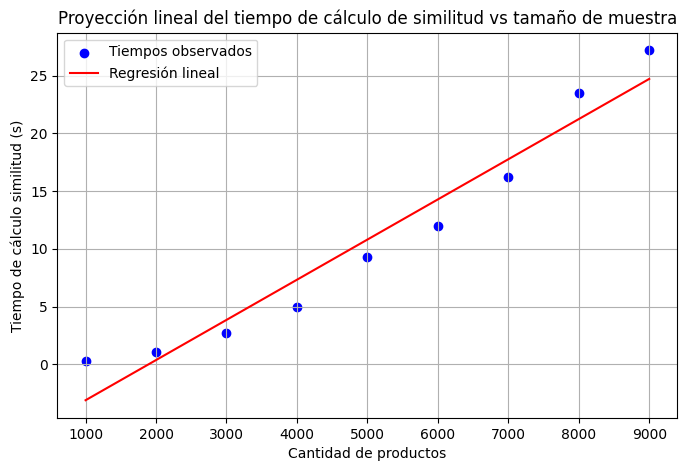

Fórmula estimada: tiempo = 0.003477 * tamaño + -6.5811
Proyección para tamaño=2: tiempo estimado = -6.5742 segundos
Proyección para tamaño=100000: tiempo estimado = 341.1479 segundos


In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

X = performance['tamano'].values.reshape(-1, 1)
y = performance['tiempos'].values

modelo_reg = LinearRegression()
modelo_reg.fit(X, y)
y_pred = modelo_reg.predict(X)

plt.figure(figsize=(8,5))
plt.scatter(performance['tamano'], performance['tiempos'], label='Tiempos observados', color='blue')
plt.plot(performance['tamano'], y_pred, label='Regresión lineal', color='red')
plt.xlabel('Cantidad de productos')
plt.ylabel('Tiempo de cálculo similitud (s)')
plt.title('Proyección lineal del tiempo de cálculo de similitud vs tamaño de muestra')
plt.legend()
plt.grid(True)
plt.show()

print(f"Fórmula estimada: tiempo = {modelo_reg.coef_[0]:.6f} * tamaño + {modelo_reg.intercept_:.4f}")

# Proyectar el tiempo de cálculo para dos tamaños de muestra dados
tamanos_a_proyectar = np.array([2, 100000]).reshape(-1,1)  
tiempos_proyectados = modelo_reg.predict(tamanos_a_proyectar)

for tam, t_est in zip(tamanos_a_proyectar.ravel(), tiempos_proyectados):
    print(f"Proyección para tamaño={tam}: tiempo estimado = {t_est:.4f} segundos")


In [109]:
### creamos un metodo para buscar en test un texto cualquiera
texto_query = "Zapatillas nike"

X_query = vectorizer.transform([texto_query])

sim = cosine_similarity(X_query, X_test).ravel()

k = 2
top_idx = np.argsort(-sim)[:k]
top_scores = sim[top_idx]
top_titles = df_test['title_fix'].iloc[top_idx].tolist()

df_similares = pd.DataFrame({
    'query': [texto_query] * k,
    'similar_title': top_titles,
    'similarity_score': top_scores
})

df_similares


,query,similar_title,similarity_score
0,Zapatillas nike,nike prestige,0.513248
1,Zapatillas nike,nike overreact sandal ispa original,0.426809


## Vamos a revosar ver otro tipo de solucion basada de embeddings y contexto (requiere mas datos pero como se comporta)
#### se va a entrenar un wordtovec dado su facilidad para manejar vectores dimensionales con representaciones vectorial

In [72]:
df_train.head(2)

,ITE_ITEM_TITLE,title_fix
0,Tênis Ascension Posh Masculino - Preto E Verme...,tenis ascension posh masculino preto e vermelho
1,Tenis Para Caminhada Super Levinho Spider Corr...,tenis para caminhada super levinho spider corrida


In [73]:
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

#generamos un metodo para tokenizar los titulos en palabras basandonos en el paquete de gensim

def tokenize(txt):
    return simple_preprocess(str(txt), deacc=True, min_len=2)  
    
sentences_train = [tokenize(t) for t in df_train["ITE_ITEM_TITLE"]]


In [74]:
sentences_train[1]

['tenis', 'para', 'caminhada', 'super', 'levinho', 'spider', 'corrida']

In [76]:
#entrenamos el modelo word2vec para que aprenda los vectores de los titulos con dimensiones de 20

w2v = Word2Vec(
    sentences=sentences_train,
    vector_size=20,   
    window=2,          
    min_count=2,      
    sg=10,              # 1 = skip-gram (mejor con datos escasos); 0 = CBOW
    workers=4,
    epochs=10
)

In [77]:
import numpy as np


#cramos un metodo para obtener el vector de un titulo, esto para poder usarlo mas adelante

def title_vector(tokens, model, normalize=True):
    vecs = [model.wv[w] for w in tokens if w in model.wv]
    if not vecs:
        return np.zeros(model.vector_size, dtype=np.float32)
    v = np.mean(vecs, axis=0)
    if normalize:
        n = np.linalg.norm(v)
        if n > 0: v = v / n
    return v

# Vectores para train y test
Xtrain_w2v = np.vstack([title_vector(tokenize(t), w2v) for t in df_train["ITE_ITEM_TITLE"]])
Xtest_w2v  = np.vstack([title_vector(tokenize(t), w2v) for t in df_test["ITE_ITEM_TITLE"]])

df_test['vector_w2v'] = Xtest_w2v.tolist()
df_train['vector_w2v'] = Xtrain_w2v.tolist()

In [78]:
df_test.head(1)

,ITE_ITEM_TITLE,title_fix,vector_w2v
0,Tênis Olympikus Esporte Valente - Masculino Kids,tenis olympikus esporte valente masculino kids,"[0.06064073368906975, 0.15334747731685638, 0.5..."


In [79]:
from sklearn.neighbors import NearestNeighbors
## vamos a crear un metodo para buscar los vecinos mas cercanos con la metrica coseno, para tener la similitud de los titulos
k = 2
nn = NearestNeighbors(n_neighbors=k, metric="cosine", algorithm="brute")
nn.fit(Xtrain_w2v)


,n_neighbors,2
,radius,1.0
,algorithm,'brute'
,leaf_size,30
,metric,'cosine'
,p,2
,metric_params,None
,n_jobs,None


In [80]:
dist, idx = nn.kneighbors(Xtest_w2v, return_distance=True) 
sim = 1 - dist

In [81]:
#en este caso como se crearon los vectores con el titulo original se mantiene el orden de los titulos
i = 0
print(df_train["ITE_ITEM_TITLE"].iloc[i])
matches_i = list(zip(df_train["ITE_ITEM_TITLE"].iloc[idx[i]].tolist(), sim[i].tolist()))
matches_i


Tênis Ascension Posh Masculino - Preto E Vermelho 


[('Tênis Kids Masculino Esportivo Olympikus V-zero  ', 0.9930692911148071),
 ('Tênis Olympikus Masculino Control / 781 - Barato', 0.9922935962677002)]

In [82]:
#creamos 
def tokenize(txt):
    return simple_preprocess(str(txt), deacc=True, min_len=2)

texto_query = "pedal para bicicleta"
tokens_query = tokenize(texto_query)

# Obtener el vector del título
X_query = title_vector(tokens_query, w2v)

sim = cosine_similarity([X_query], Xtest_w2v).ravel()

k = 3
top_idx = np.argsort(-sim)[:2]
top_titles = df_test["title_fix"].iloc[top_idx].tolist()
top_scores = sim[top_idx]

df_result = pd.DataFrame({
    "similar_title": top_titles,
    "similarity_score": top_scores
})

print(df_result)


                                       similar_title  similarity_score
0  ciclismo mountain bike luvas de bicicleta de b...          0.954777
1                bicicleta caloi 10 para restauracao          0.943120


### en el documento se hace refencia a tres categorias, pero no se dice cuales con un K-means vamos a identificarlas
#### se utiliza los embedding anteriores como entradas para tratar de determinar en que direcciones se agrupan 

In [83]:

from sklearn.cluster import KMeans

X_w2v = np.vstack(df_train["vector_w2v"].values)

kmeans = KMeans(n_clusters=3, random_state=22, n_init=10)
df_train["segmento_kmeans"] = kmeans.fit_predict(X_w2v)


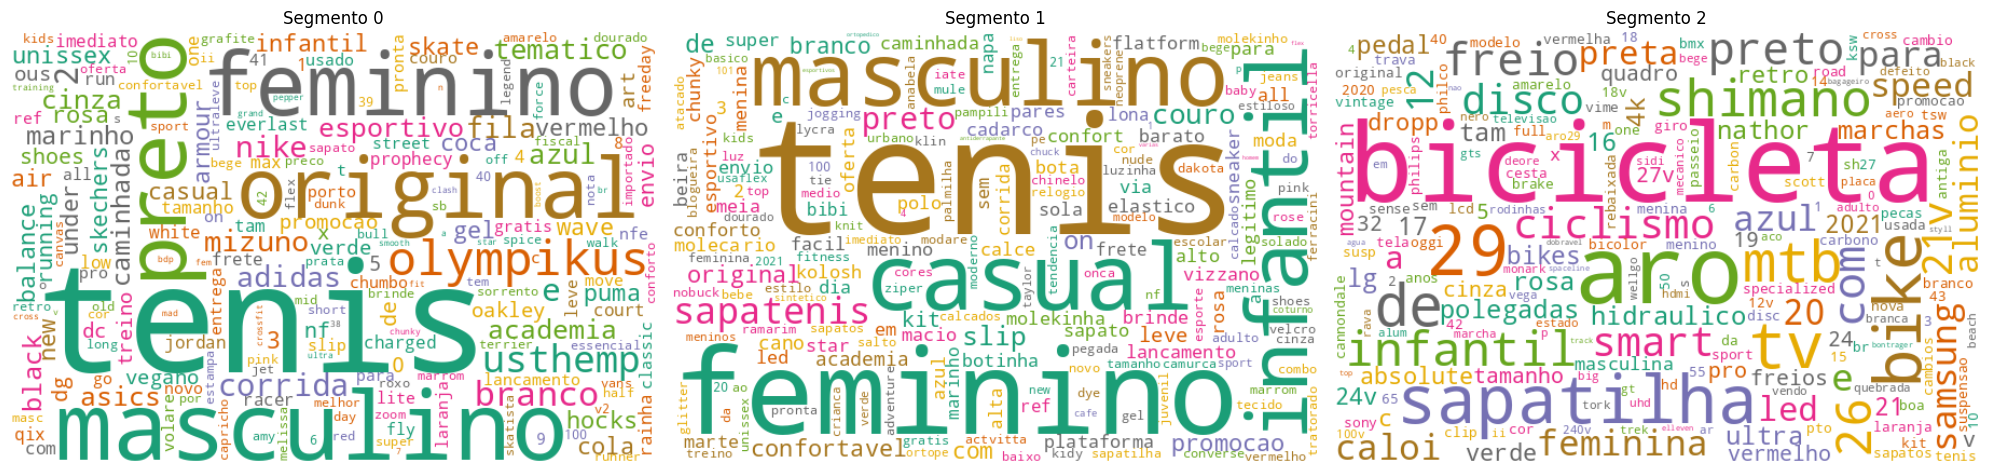

In [84]:
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
for seg in sorted(df_train['segmento_kmeans'].unique()):
    titles = df_train[df_train['segmento_kmeans'] == seg]['title_fix']
    words = [w for t in titles for w in t.split()]
    word_freq = Counter(words)
    wc = WordCloud(width=600, height=400, background_color='white', colormap='Dark2').generate_from_frequencies(word_freq)
    axes[seg].imshow(wc, interpolation='bilinear')
    axes[seg].set_title(f'Segmento {seg}')
    axes[seg].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# se podria hablar de tres categorias, muy clara DEPORTES, y hablamos de ROPA DEPORTIVA tanto para Infantil y Adultos